In [1]:
# %matplotlib widget
# 
# import matplotlib as mpl
# mpl.rcParams['savefig.dpi'] = 80
# mpl.rcParams['figure.dpi'] = 50

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
import os
import glob
import imageio
from sklearn.neighbors import NearestNeighbors
from joblib import Parallel, delayed
import pykitti
from util import *
from colmap_model import *

In [2]:
def read_array(path):
    with open(path, "rb") as fid:
        width, height, channels = np.genfromtxt(fid, delimiter="&", max_rows=1,
                                                usecols=(0, 1, 2), dtype=int)
        fid.seek(0)
        num_delimiter = 0
        byte = fid.read(1)
        while True:
            if byte == b"&":
                num_delimiter += 1
                if num_delimiter >= 3:
                    break
            byte = fid.read(1)
        array = np.fromfile(fid, np.float32)
    array = array.reshape((width, height, channels), order="F")
    depth_map = np.transpose(array, (1, 0, 2)).squeeze()
    min_depth, max_depth = np.percentile(depth_map, [5, 95])
    depth_map[depth_map < min_depth] = min_depth
    depth_map[depth_map > max_depth] = max_depth
    return depth_map


In [3]:
# the binary depth files are in the "bin_dir" generated by colmap
# the destination is the KITTI data folder

base_dir = '/Users/dewalgupta/Documents/ucsd/lab/data/'
bin_dir = os.path.join(base_dir, 'colmap/04_color/dense/stereo/depth_maps')
dest_dir = os.path.join(base_dir, 'KITTI/raw/2011_09_30/2011_09_30_drive_0016_sync/post_processed_depth')
img_dir = os.path.join(base_dir, 'KITTI/raw/2011_09_30/2011_09_30_drive_0016_sync/image_02/data')

def generate_depth():
    files = glob.glob(os.path.join(bin_dir, "*geometric*"))
    count = 0
    for f in files:
        fname = os.path.basename(f)
        i = fname.find('geometric')
        fname = fname[:i-1]
        fpath = os.path.join(dest_dir, fname)
        if os.path.isfile(fpath):
            continue

        nparray = read_array(f)
        nparray = nparray * 1000
        nparray = nparray.astype(np.uint16)
        imageio.imsave(fpath, nparray)
        count += 1

    print("Found " + str(len(files)) + " binary depth maps. Created " + str(count) + " png files.")
    
    
def generate_one(frame, save=True):
    fname = frame
    if type(frame) is int: 
        fname = str(frame) + ".png"
        zeros = '0' * (14 - len(fname))
        fname = zeros + fname
    
    bin_file = fname + ".geometric.bin"
    bin_fpath = os.path.join(bin_dir, bin_file)
    fpath = os.path.join(dest_dir, fname)

    nparray = read_array(bin_fpath)
    nparray = nparray * 1000
    nparray = nparray.astype(np.uint16)
    if save:
        imageio.imsave(fpath, nparray)
    
    return nparray

uint16
8372
(366, 1215)


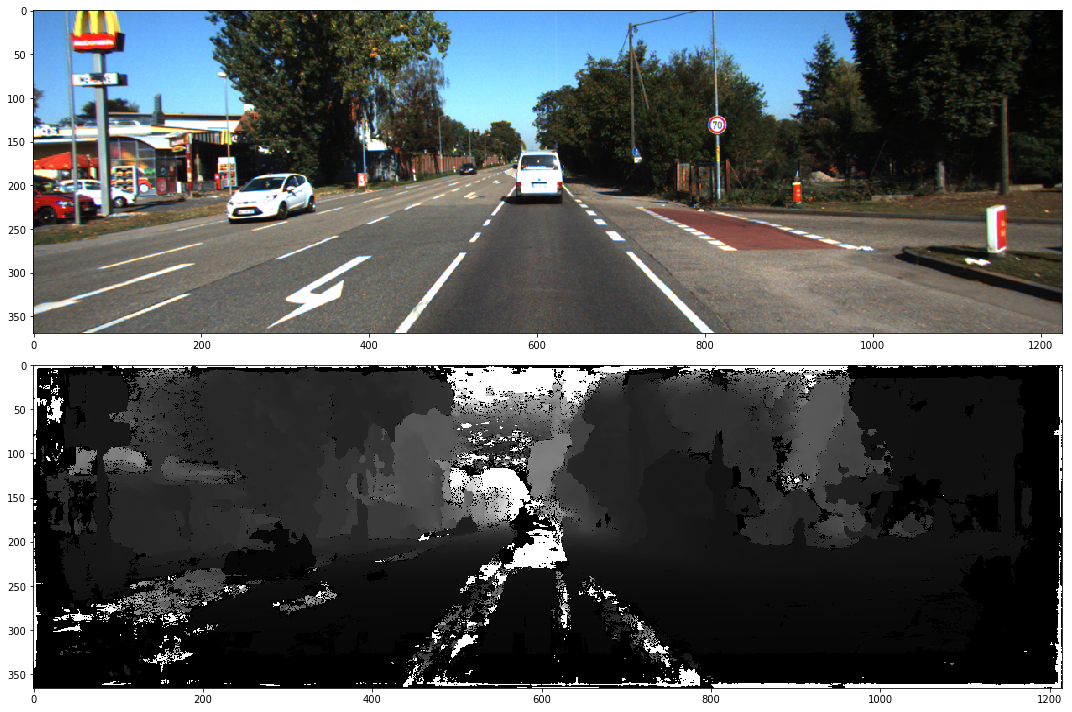

In [53]:
png_image_files = sorted(glob.glob(os.path.join(img_dir, "*.png")))
png_depth_files = sorted(glob.glob(os.path.join(dest_dir, "*.png")))

ex_idx = 1
ex_dep_file = png_depth_files[ex_idx]
ex_img_file = png_image_files[ex_idx]
dep = imageio.imread(ex_dep_file)
img = imageio.imread(ex_img_file)

# Should show that the image was encoded with uint16 with the orignal 
# COLMAP depth values scaled by a factor of 1000.
print(dep.dtype)
print(dep.max())
print(dep.shape)

plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.imshow(img, aspect = "auto")
plt.subplot(2, 1, 2)
plt.imshow(dep, cmap='gray', aspect = "auto")
plt.tight_layout()
plt.show()

In [5]:
def process(depimg, plot=True, knn=None, thres=1.0000001):
    dep = np.copy(depimg)
    img_shape = dep.shape
    points = []
    for i in range(img_shape[0]):
        for j in range(img_shape[1]):
            points += [np.array([i, j, dep[i][j]])]
            
    points = np.array(points)
    
    if knn is None:
        knn = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(points)
        
    distances, indices = knn.kneighbors(points)
    p = np.percentile(distances[:, 1], [0, 25, 50, 75, 100])
#     print("distance percentiles: 0, 25, 50, 75, 100")
#     print(p[0], p[1], p[2], p[3], p[4])

    for i, dist in enumerate(distances[:, 1]):
        if dist > thres:
            x = int(points[i][0])
            y = int(points[i][1])
            dep[x][y] = 0

    if plot:
        cond = dep == 0
        cond = np.stack((cond, cond, cond), axis=2)
        redimg = np.zeros(cond.shape, dtype=np.float32)
        redimg[:, :, 0] = 1.0
        color = dep.astype(np.float32) / dep.max()
        color = np.stack((color, color, color), axis=2)
        
        color_depth = np.where(cond, redimg, color)
        
        plt.figure(figsize=(20, 10))
        plt.imshow(color_depth)
        plt.show()
        
    return dep, knn

In [22]:
pdep, n = process(dep, thres=5e10)
pdep, _ = process(dep, knn=n, thres=1e10) # original image with no disqualifying pixels based on nn
pdep, _ = process(dep, knn=n, thres=150)
pdep, _ = process(dep, knn=n, thres=10)

FigureCanvasNbAgg()

FigureCanvasNbAgg()

FigureCanvasNbAgg()

FigureCanvasNbAgg()

In [6]:
proc_depth_dir = os.path.join(base_dir, 'KITTI/raw/2011_09_30/2011_09_30_drive_0016_sync/post_processed_depth')
count = 0
for f in png_depth_files:
    fname = os.path.basename(f)
    dest_fname = os.path.join(proc_depth_dir, fname)
    if os.path.isfile(dest_fname):
        continue
        
    print(fname)
    count += 1
    dep = imageio.imread(f)
    pdep, _ = process(dep, thres=10, plot=False)
    imageio.imwrite(dest_fname, pdep)

print("Found " + str(len(png_depth_files)) + " depth files. Processed " + str(count) + " of them.")

Found 279 depth files. Processed 0 of them.


In [26]:
# parallel version
proc_depth_dir = os.path.join(base_dir, 'KITTI/raw/2011_09_30/2011_09_30_drive_0016_sync/post_processed_depth')
def post_proc_parallel(f):
    fname = os.path.basename(f)
    dest_fname = os.path.join(proc_depth_dir, fname)
    if os.path.isfile(dest_fname):
        return
        
    try:
        dep = imageio.imread(f)
        pdep, _ = process(dep, thres=10, plot=False)
        imageio.imwrite(dest_fname, pdep)
    except: 
        print("something blew up in file " + fname)
    
    
# Parallel(n_jobs=-1)(delayed(post_proc_parallel)(file) for file in png_depth_files)

## Testing

The image above puts '1000.0' as a value where ever the depth is unavailable. However, this is hard to visualize in a grayscale image. Therefore, we make sure the right pixels are marked by converting the grayscale to an RGB image and then where ever the value was 1000.0, we put a red pixel at that location. The two pictures (the one above this cell, and the one below this cell) should match.

In [ ]:
# cond = pdep0 == 1000.0
# cond = np.stack((cond,cond,cond), axis=2)
# origimg = np.stack((dep0,dep0,dep0), axis=2)
# redimg = np.zeros(cond.shape, dtype=np.int)
# redimg[:, :, 0] = 255
# testimg = np.where(cond, redimg, origimg)

# plt.figure(figsize=(20, 10))
# plt.imshow(testimg)

# Testing Depth Map Accuracy
Test the accuracy by reprojecting 2 frame's points back into 3d space - should line up decently


In [6]:
kitti_dir = os.path.join(base_dir, "KITTI/raw")
date = '2011_09_30'
drive = '0016'

data = pykitti.raw(kitti_dir, date, drive)
color = [imageio.imread(f) for f in png_image_files]
depths = [imageio.imread(f) for f in png_depth_files]
depths = [d.astype(np.float32)/1000.0 for d in depths]

In [5]:
colmap_dir = os.path.join(base_dir, 'colmap/04_color/dense/sparse')
points3d = read_points3d_binary(os.path.join(colmap_dir, 'points3D.bin'))
images = read_images_binary(os.path.join(colmap_dir, 'images.bin'))
camera = read_cameras_binary(os.path.join(colmap_dir, 'cameras.bin'))

In [7]:
f1 = 0
f2 = 4
p1 = images[f1+1].pose
p2 = images[f2+1].pose

In [8]:
fx = camera[1].params[0]
fy = camera[1].params[1]
cx = camera[1].params[2]
cy = camera[1].params[3]

K = np.array([[fx, 0.0, cx], 
              [0.0, fy, cy], 
              [0.0,  0.0, 1.0]])

K_inv = np.array([[1/fx, 0.0, -cx/fx], 
                  [0.0, 1/fy, -cy/fy], 
                  [0.0,  0.0, 1.0]])

### Check the 3D points generated by COLMAP itself
Colmap generates the sparse 3d points - project them back into two frames and see if they match up.

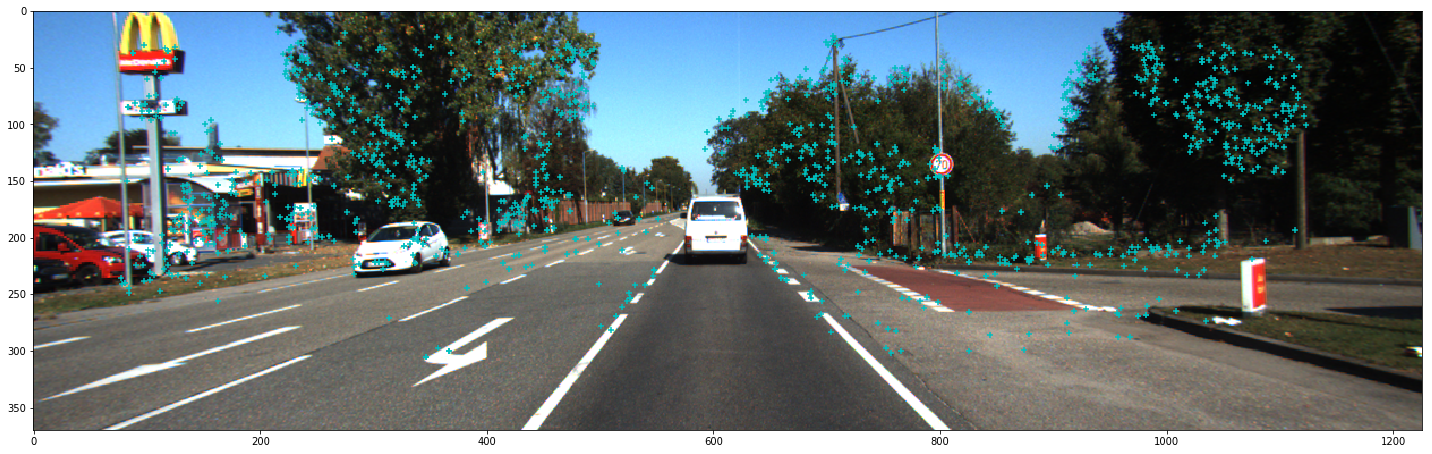

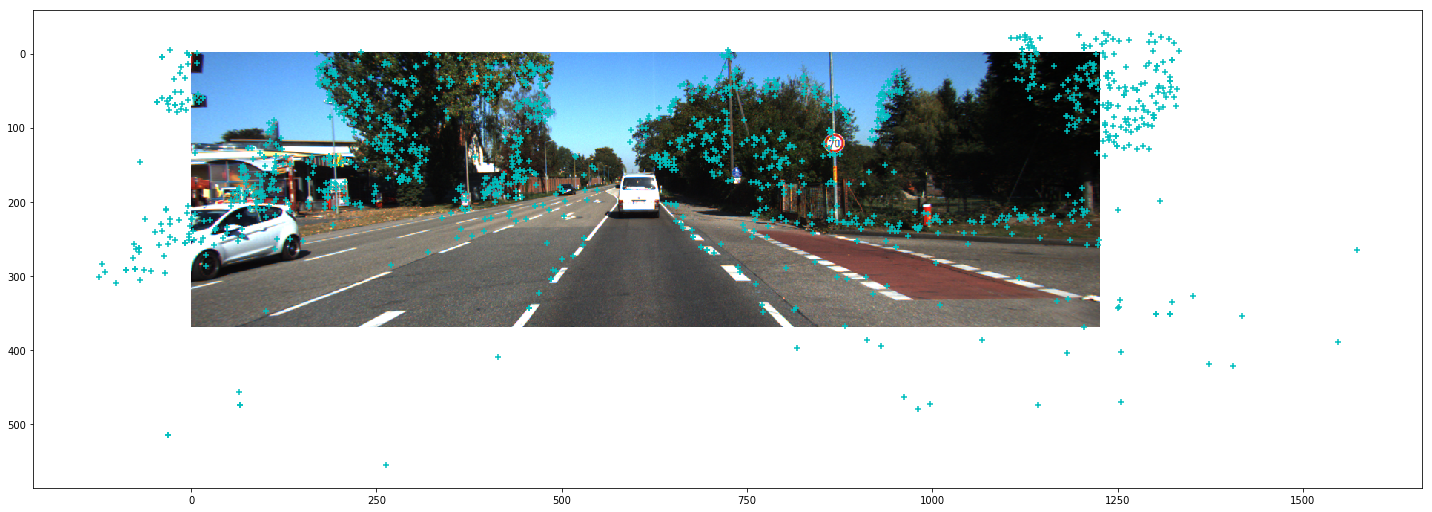

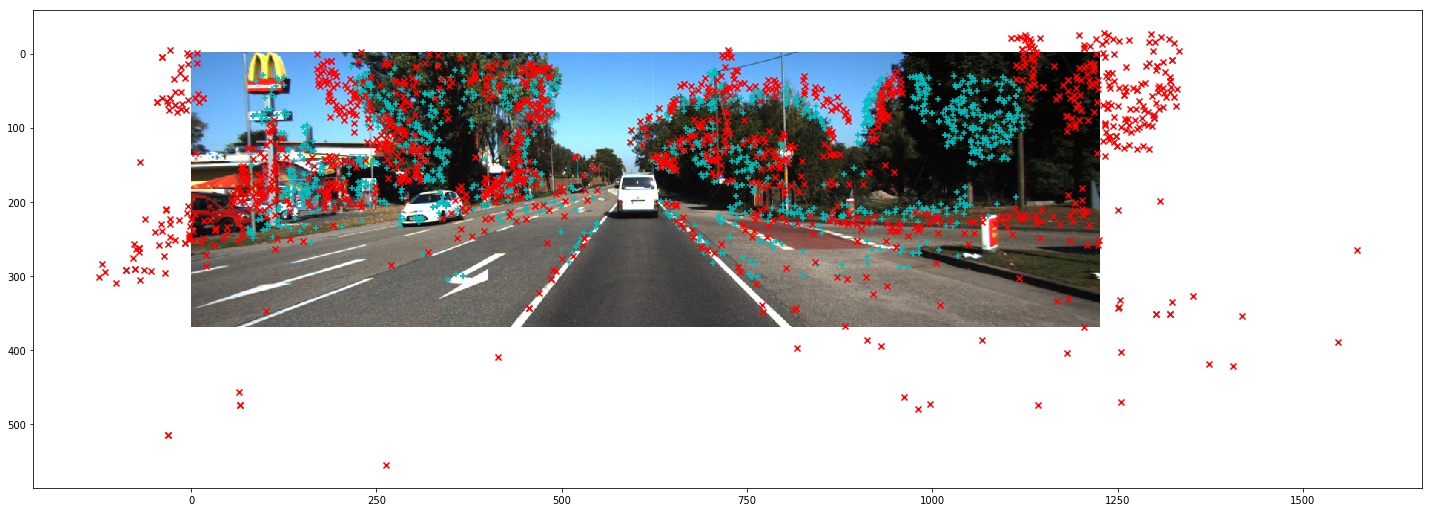

In [23]:
# filter out the 3d points that are not found in this frame AND 
# that are only found within this 50 frames of the initial frame (because that will create outliers)

world = np.array([points3d[p].xyz for p in points3d if f1+1 in points3d[p].image_ids and f1+1+points3d[p].image_ids[0] < 50])

# Tcw_f1 = K @ np.linalg.inv(p1)[:3]
Tcw_f1 = K @ p1[:3]
pts1 = np.array([Tcw_f1 @ p for p in toHomogeneous(world)])
pts1 = fromHomogeneous(pts1)
plot_img(color[f1], pts1) 
# print(len(pts1))

Tcw_f2 = K @ p2[:3]
pts2 = np.array([Tcw_f2 @ p for p in toHomogeneous(world)])
pts2 = fromHomogeneous(pts2)
plot_img(color[f2], pts2) 
plot_img(color[f1], pts1, pts2=pts2) 



### Project "Random" Points
Create random points in a frame and project to the world, and then to another frame. Instead of completely random points though, we will use the keypoints generated by COLMAP for the first frame. 

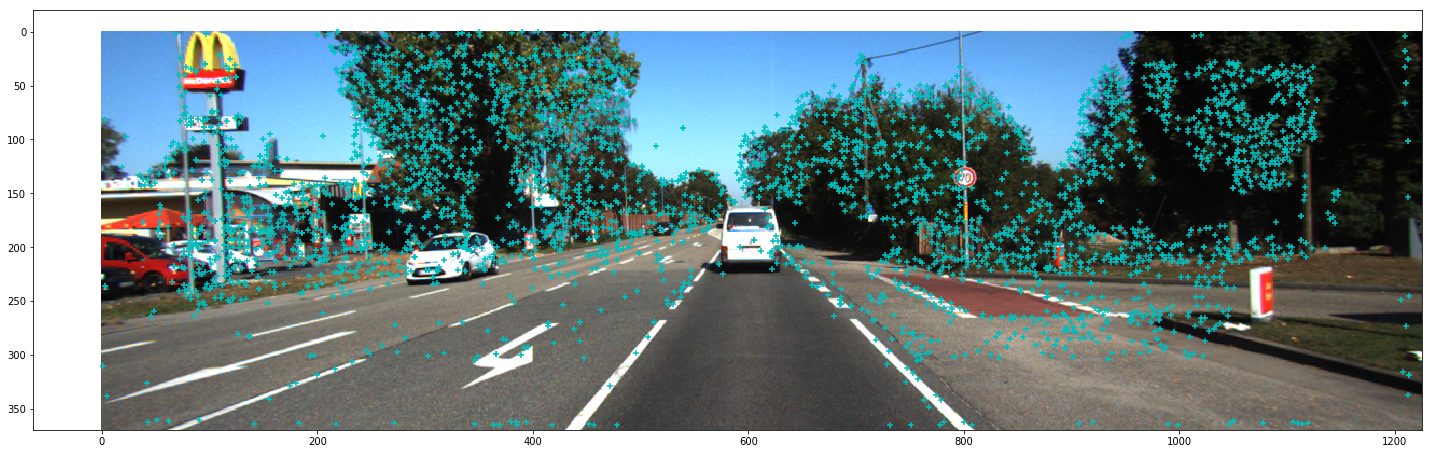

In [42]:
rpts = images[f1+1].xys.astype(int)
rpts = np.array([p for p in rpts if not np.isclose(depths[f1].T[p[0], p[1]], 0.0)])

rpts_deps = np.array([depths[f1].T[p[0], p[1]] for p in rpts])

plot_img(color[f1], rpts)

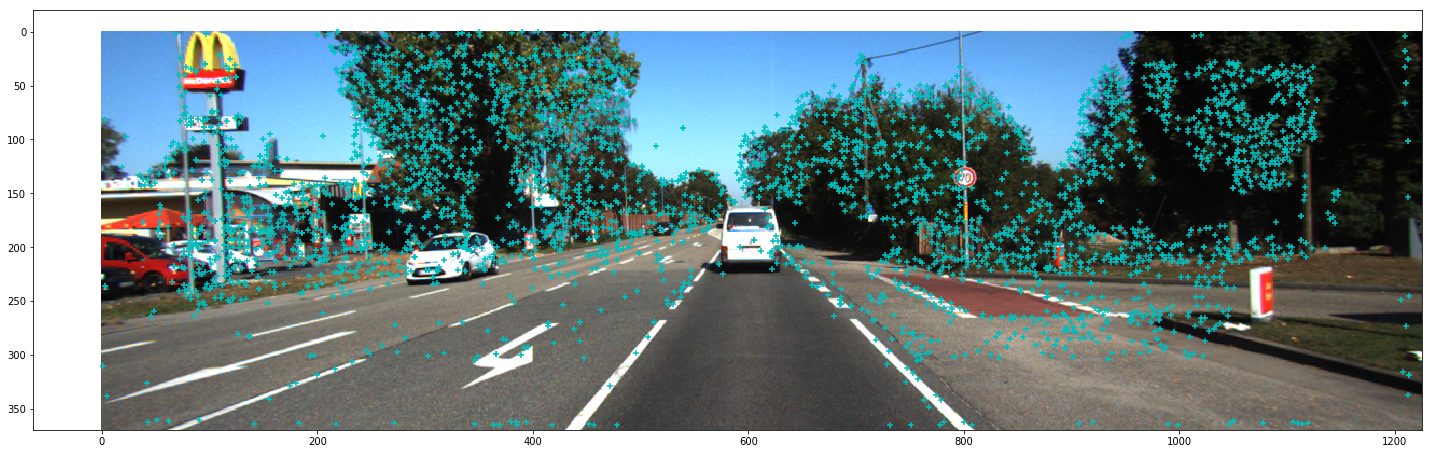

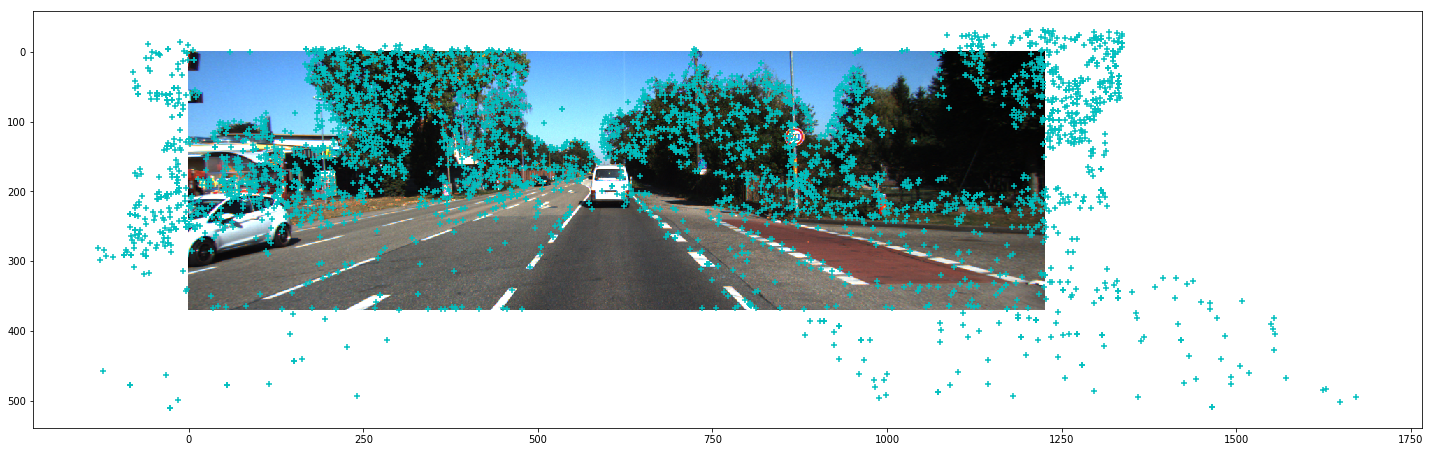

In [91]:
t = K_inv @ toHomogeneous(rpts).T
dep_mul = np.stack((rpts_deps, rpts_deps, rpts_deps))

world = toHomogeneous(np.multiply(t, dep_mul).T)
# world = p1 @ world.T
world = np.linalg.inv(p1) @ world.T
world = world.T

# Twc_f1 = K @ np.linalg.inv(p1)[:3]
Twc_f1 = K @ p1[:3]
img1_points = np.array([Twc_f1 @ p for p in world])
img1_points = fromHomogeneous(img1_points)

plot_img(color[f1], img1_points)

# Twc_f2 = K @ np.linalg.inv(p2)[:3]
Twc_f2 = K @ p2[:3]
img2_points = np.array([Twc_f2 @ p for p in world])
img2_points = fromHomogeneous(img2_points)

plot_img(color[f2], img2_points)

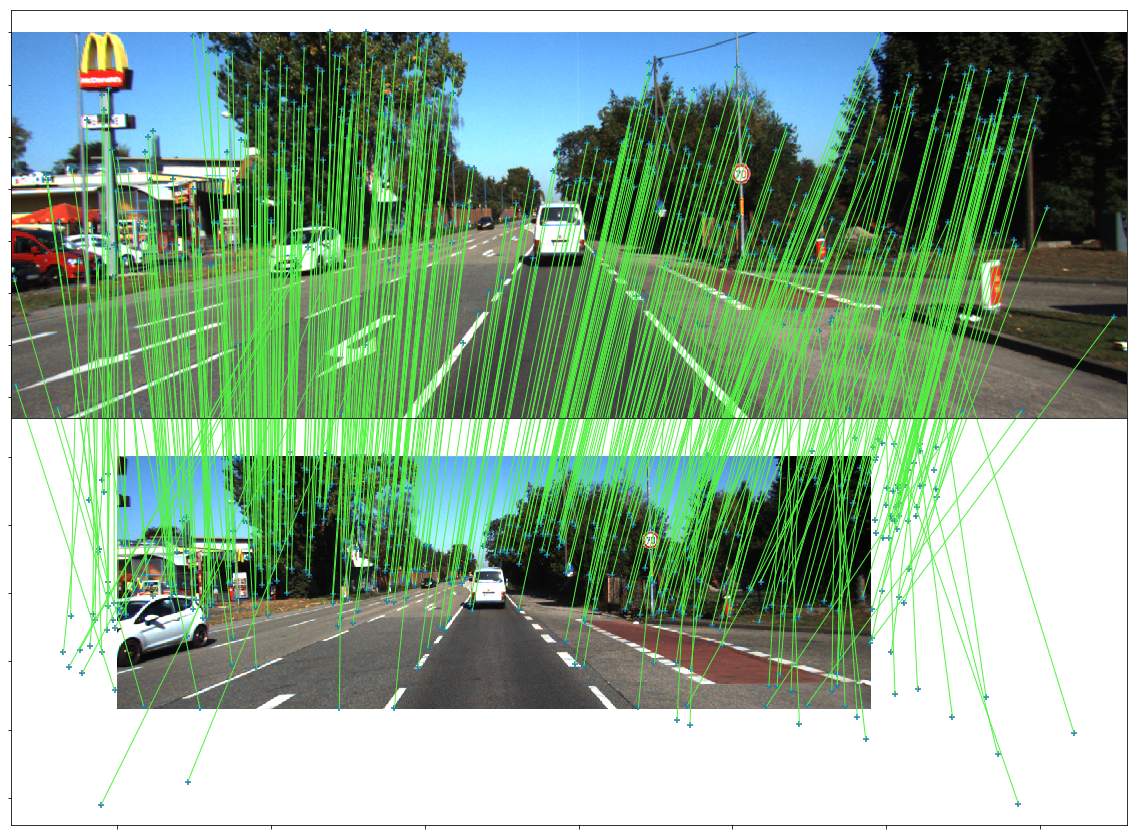

In [96]:
random_sample = np.random.choice(len(img1_points), 500, replace=False)
rand_img1 = img1_points[random_sample]
rand_img2 = img2_points[random_sample]

plot_corr(color[f1], color[f2], rand_img1, rand_img2)